<a href="https://colab.research.google.com/github/IralaElbio/DataScience/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
import ast
from sklearn.utils import resample
import category_encoders as ce
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/dataset_v2/train.parq")
Shodan = pd.read_csv("/content/drive/MyDrive/dataset_v2/shodan_df_hashed.csv")

In [ ]:
data.drop_duplicates(subset = ["watcher_as_num","attacker_ip_enum","attack_type"], inplace = True)
data.drop(["watcher_as_num", "watcher_uuid_enum", "attacker_as_num", "watcher_as_name", "attack_time"],axis = 1,inplace = True)

In [ ]:
RANDOM_STATE = 24
data["attacker_as_name"] = data["attacker_as_name"].map(lambda x: x.lower())

# info df

null analisis

In [ ]:
data.isna().sum()/data.shape[0] * 100

watcher_country     0.658598
attacker_country    0.020323
attacker_as_name    0.073945
attack_type         0.000000
attacker_ip_enum    0.000000
label               0.000000
dtype: float64

add unknown category to the null data

In [ ]:
data["attacker_as_name"].fillna("unknown", inplace = True)

data["attacker_country"] = data["attacker_country"].cat.add_categories("unknown")
data["attacker_country"].fillna("unknown", inplace = True)

no hay nulos

In [ ]:
data.isna().sum()/data.shape[0] * 100

watcher_country     0.658598
attacker_country    0.000000
attacker_as_name    0.000000
attack_type         0.000000
attacker_ip_enum    0.000000
label               0.000000
dtype: float64

# feature engineering

## concatenate the names of the countries

In [ ]:
data["Countries"] = data["watcher_country"].astype(str) + "-" + data["attacker_country"].astype(str)

In [ ]:
data.drop(["watcher_country","attacker_country"], axis = 1, inplace = True)

## Shodan Ports


Functions to separate ports and protocols

In [ ]:
def Port(keys):
  res = set()
  if len(keys) == 0:
    res.add("unknown")
    return res
  for key in keys:
    puerto = key.split("/")[0]
    res.add(puerto)
  return res


def Protocol(keys):
  res = set()
  if len(keys) == 0:
    res.add("unknown")
    return res
  for key in keys:
    puerto = key.split("/")[1]
    res.add(puerto)
  return res

In [ ]:
Shodan["port"] = Shodan["shodan_info"].map(lambda x: Port(ast.literal_eval(x).keys()))
Shodan["protocol"] = Shodan["shodan_info"].map(lambda x: Protocol(ast.literal_eval(x).keys()))

In [ ]:
Shodan.head(5)

,shodan_info,attacker_ip_enum,port,protocol
0,{},5915,{unknown},{unknown}
1,"{'22/tcp': {'headers_hash': None, 'jarm': None...",3325,{22},{tcp}
2,{},8416,{unknown},{unknown}
3,{},1213,{unknown},{unknown}
4,{},9185,{unknown},{unknown}


Merge data and Shodan ports

In [ ]:
data = data.merge(Shodan[["attacker_ip_enum","port"]], on = "attacker_ip_enum", how = "left")

### Protocol

In [ ]:
protocol = Shodan[["attacker_ip_enum","protocol","port"]].explode("protocol")

In [ ]:
protocol = protocol.groupby(["attacker_ip_enum","protocol"]).count().unstack().fillna(0).reset_index()

In [ ]:
protocol.columns = ["attacker_ip_enum","unknown","tcp","udp"]

In [ ]:
data = data.merge(protocol, on = "attacker_ip_enum", how = "left")

## Take the service in attack_type

In [ ]:
data["service"] = data["attack_type"].map(lambda x: x.split(":")[0])
data.drop("attack_type",axis = 1, inplace = True)

# Data management

## Creating validation and test

### Validation and test mantaining data dispersion

GroupShuffleSplit to separate the data with label 0 and label 1 in a 80-20 to mantain data dispersion

In [ ]:
data1 = data[data["label"] == 1]
data0 = data[data["label"] == 0]

In [ ]:
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = RANDOM_STATE)
split0 = splitter.split(data0, groups= data0["attacker_ip_enum"])
train_inds0, test_inds0 = next(split0)

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = RANDOM_STATE)
split1 = splitter.split(data1, groups= data1["attacker_ip_enum"])
train_inds1, test_inds1 = next(split1)

train0 = data0.iloc[train_inds0]
valid0 = data0.iloc[test_inds0]

train1 = data1.iloc[train_inds1]
valid1 = data1.iloc[test_inds1]

Concat the data with 0 and 1

In [ ]:
train = shuffle(pd.concat([train1,train0]), random_state= RANDOM_STATE)
valid = shuffle(pd.concat([valid1,valid0]), random_state= RANDOM_STATE)

clear memory

In [ ]:
datos0 = ""
datos1 = ""
datos = ""
train0 = ""
valid0 = ""
train1 = ""
valid1 = ""

# Mean

## Attacker_as_name vs ports

Take the ports and as_name, calculate mean for each port associated with the same attacker_as_name.

for example: the case of "sri lanka telecom internet" which have numerous ports.

In [ ]:
train.head(5)

,attacker_as_name,attacker_ip_enum,label,Countries,port,unknown,tcp,udp,service
1401946,rcs & rds,53005,0,DE-RO,{unknown},0.0,0.0,1.0,http
1023231,viettel group,34156,0,PL-VN,{unknown},0.0,0.0,1.0,http
4980524,pt panglima kamayo media,193534,0,GR-ID,"{2087, 443, 8443, 8006, 2000, 2083, 80, 2082, ...",1.0,1.0,0.0,http
2656816,signet b.v.,101374,0,PL-NL,"{10000, 443, 2222, 21, 80, 587, 25, 10001, 3306}",1.0,0.0,0.0,http
667166,sri lanka telecom internet,27122,0,US-LK,"{8089, 7547, 80, 1434, 445, 8085}",1.0,1.0,0.0,http


I take the best combination based on the mean

"sri lanka telecom internet" with port 80 = 0.2.

"sri lanka telecom internet" with port 53 = 0.8.

I choose port 80.


### train

In [ ]:
att_as_name_vs_p = train[["attacker_as_name", "label", "port"]].explode("port")

In [ ]:
att_as_name_vs_p.head()

,attacker_as_name,label,port
1401946,rcs & rds,0,unknown
1023231,viettel group,0,unknown
4980524,pt panglima kamayo media,0,2087
4980524,pt panglima kamayo media,0,443
4980524,pt panglima kamayo media,0,8443


In [ ]:
att_as_name_vs_p = att_as_name_vs_p.groupby(["attacker_as_name","port"]).mean()

In [ ]:
att_as_name_vs_p.columns = ["mean"]

In [ ]:
att_as_name_vs_p.head()

mean
attacker_as_name      port      
''it fruit'' s.r.l.   135    0.0
                      3389   0.0
                      445    0.0
                      5985   0.0
(aq) networks limited 1723   0.0

In [ ]:
att_as_name_vs_p_map = att_as_name_vs_p["mean"].to_dict()
# clear memory
att_as_name_vs_p = ""

make a new column with "as_name" and "ports" in a array

In [ ]:
train["att_as_name_vs_ports"] = train["attacker_as_name"].apply(lambda x: [str(x)]) + train["port"].apply(list)

In [ ]:
train.head()

,attacker_as_name,attacker_ip_enum,label,Countries,port,unknown,tcp,udp,service,att_as_name_vs_ports
1401946,rcs & rds,53005,0,DE-RO,{unknown},0.0,0.0,1.0,http,"[rcs & rds, unknown]"
1023231,viettel group,34156,0,PL-VN,{unknown},0.0,0.0,1.0,http,"[viettel group, unknown]"
4980524,pt panglima kamayo media,193534,0,GR-ID,"{2087, 443, 8443, 8006, 2000, 2083, 80, 2082, ...",1.0,1.0,0.0,http,"[pt panglima kamayo media, 2087, 443, 8443, 80..."
2656816,signet b.v.,101374,0,PL-NL,"{10000, 443, 2222, 21, 80, 587, 25, 10001, 3306}",1.0,0.0,0.0,http,"[signet b.v., 10000, 443, 2222, 21, 80, 587, 2..."
667166,sri lanka telecom internet,27122,0,US-LK,"{8089, 7547, 80, 1434, 445, 8085}",1.0,1.0,0.0,http,"[sri lanka telecom internet, 8089, 7547, 80, 1..."


The function takes a list in the following format: ['as_name', mean_port_1, mean_port_2, mean_port_3, etc.].
It calculates and returns the mean whit the maximum value

In [ ]:
def max_mean_att_ports(list_p):
  as_name = list_p[0]
  res = []
  for port in list_p[1:]:
    res.append(att_as_name_vs_p_map.get((as_name, port), 0))
  return max(res)


In [ ]:
train["att_as_name_vs_ports"] = train["att_as_name_vs_ports"].map(lambda x: max_mean_att_ports(x))

In [ ]:
train.drop(["attacker_as_name"], axis = 1, inplace = True)

### valid

In [ ]:
valid["att_as_name_vs_ports"] = valid["attacker_as_name"].apply(lambda x: [str(x)]) + valid["port"].apply(list)

In [ ]:
valid["att_as_name_vs_ports"] = valid["att_as_name_vs_ports"].map(lambda x: max_mean_att_ports(x))

In [ ]:
valid.drop(["attacker_as_name"], axis = 1, inplace = True)

## Ports mean

### train

In [ ]:
ports = train[["label","port"]]

In [ ]:
ports = ports.explode("port").groupby("port").mean()

In [ ]:
ports.columns = ["mean"]

In [ ]:
ports.head()

,mean
port,
100,0.000000
1000,0.000000
10000,0.035419
10001,0.189660
10099,0.000000


In [ ]:
ports_dict = ports["mean"].to_dict()
ports = ""

function to get the max mean of each port then devide for the length to either "normalize" or "pelalize" rows with numerous open ports

In [ ]:
def mean_ports(ports):
  means = []
  for port in ports:
    means.append(ports_dict.get(port,0))
  return max(means) / (len(means))


In [ ]:
train["port"] = train["port"].map(lambda x: mean_ports(x))

### valid

In [ ]:
valid["port"] = valid["port"].map(lambda x: mean_ports(x))

# Encoding

In [ ]:
train

,attacker_ip_enum,label,Countries,port,unknown,tcp,udp,service,att_as_name_vs_ports
1401946,53005,0,DE-RO,0.000743,0.0,0.0,1.0,http,0.000000
1023231,34156,0,PL-VN,0.000743,0.0,0.0,1.0,http,0.000000
4980524,193534,0,GR-ID,0.023944,1.0,1.0,0.0,http,0.000000
2656816,101374,0,PL-NL,0.021073,1.0,0.0,0.0,http,0.051690
667166,27122,0,US-LK,0.011309,1.0,1.0,0.0,http,0.000000
...,...,...,...,...,...,...,...,...,...
4518322,175203,0,US-US,0.056182,1.0,0.0,0.0,http,0.000000
519598,10598,0,NL-SG,0.000743,0.0,0.0,1.0,http,0.000000
1474087,55267,0,LV-IN,0.004013,1.0,1.0,0.0,http,0.000000
2552962,96962,0,AU-KE,0.000743,0.0,0.0,1.0,http,0.000000


## Creating train and validation

In [ ]:
train.drop_duplicates(inplace = True)
valid.drop_duplicates(inplace = True)

In [ ]:
train.drop("attacker_ip_enum", inplace = True, axis = 1)
valid.drop("attacker_ip_enum", inplace = True, axis = 1)

In [ ]:
y_train = train["label"]
x_train = train.drop("label", axis=1)

y_valid = valid["label"]
x_valid = valid.drop("label", axis=1)

## Columns to binary

In [ ]:
binary_columns = ["Countries"]

encoder = ce.BinaryEncoder(cols= binary_columns)

x_train = encoder.fit_transform(x_train)

x_valid = encoder.transform(x_valid)

binary columns to int8

In [ ]:
binary_col = [col for col in x_train.columns if "paises" in col]

In [ ]:
x_train[binary_col] = x_train[binary_col].astype('int8')

## Service OHE

In [ ]:
ohe_service = OneHotEncoder(drop = "first")
encoded_serv = ohe_service.fit_transform(x_train[["service"]]).toarray()

x_train.drop("service", inplace = True, axis = 1)
x_train[ohe_service.categories_[0][1:]] = encoded_serv

In [ ]:
encoded_serv = ohe_service.transform(x_valid[["service"]]).toarray()

x_valid.drop("service", inplace = True, axis = 1)
x_valid[ohe_service.categories_[0][1:]] = encoded_serv

# Random Forest Default

In [ ]:
x_train.head()

,Countries_0,Countries_1,Countries_2,Countries_3,Countries_4,Countries_5,Countries_6,Countries_7,Countries_8,Countries_9,...,udp,att_as_name_vs_ports,ftp,http,pop3/imap,sip,smb,ssh,telnet,windows
1401946,0,0,0,0,0,0,0,0,0,0,...,1.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1023231,0,0,0,0,0,0,0,0,0,0,...,1.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4980524,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2656816,0,0,0,0,0,0,0,0,0,0,...,0.0,0.05169,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
667166,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
random_forest = RandomForestClassifier(random_state = RANDOM_STATE, n_jobs=-1)


random_forest.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=24)

In [ ]:
y_pred = random_forest.predict(x_valid)

In [ ]:
f1_score(y_valid, y_pred)

0.7183664360633788

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    173481
           1       0.76      0.68      0.72      4728

    accuracy                           0.99    178209
   macro avg       0.88      0.84      0.86    178209
weighted avg       0.99      0.99      0.99    178209



# Random forest random seach

In [ ]:
param_dist = {
    'n_estimators': [20, 40, 60, 80, 68, 70, 90, 110],
    'max_depth': [20, 10, 15, 5, None],
    'criterion' : ["gini", "entropy", "log_loss"],
    'max_features': ["sqrt", "log2", None],
    'min_samples_split': [3, 7, 9, 10, 12],
    'min_samples_leaf': [3, 7, 9, 10, 12],
    'max_samples': [None, 0.5, 0.7, 0.9],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}]
    }

In [ ]:
random_forest2 = RandomForestClassifier(random_state = RANDOM_STATE, n_jobs=-1)

In [ ]:
random_search = RandomizedSearchCV(random_forest2, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1', random_state=RANDOM_STATE)

random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=24),
                   param_distributions={'class_weight': [None, 'balanced',
                                                         {0: 1, 1: 2}],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [20, 10, 15, 5, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': [None, 0.5, 0.7, 0.9],
                                        'min_samples_leaf': [3, 7, 9, 10, 12],
                                        'min_samples_split': [3, 7, 9, 10, 12],
                                        'n_estimators': [20, 40, 60, 80, 68, 70,
                                                         90, 110]},
                   random_state=24, scoring='f1')

In [ ]:
random_search.best_score_

0.8875645876850277

In [ ]:
random_search.best_params_

{'n_estimators': 68,
 'min_samples_split': 9,
 'min_samples_leaf': 9,
 'max_samples': None,
 'max_features': None,
 'max_depth': 15,
 'criterion': 'gini',
 'class_weight': None}

In [ ]:
random_forest_rs = random_search.best_estimator_

In [ ]:
pred = random_forest_rs.predict(x_valid)

In [ ]:
f1_score(y_valid, pred)

0.7245142981881685

In [ ]:
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    173481
           1       0.75      0.70      0.72      4728

    accuracy                           0.99    178209
   macro avg       0.87      0.85      0.86    178209
weighted avg       0.99      0.99      0.99    178209



# Test Kaggle

In [ ]:
test = pd.read_parquet("/content/drive/MyDrive/dataset_v2/test.parq")

In [ ]:
test.drop(["attack_time","watcher_as_num", "watcher_uuid_enum","attacker_as_num", "watcher_as_name"],axis = 1,inplace = True)

In [ ]:
test.drop_duplicates("attacker_ip_enum", inplace = True)

In [ ]:
test["attacker_as_name"] = test["attacker_as_name"].map(lambda x: x.lower())

## INFO DF

In [ ]:
test.isna().sum()/test.shape[0] * 100

watcher_country     1.671388
attacker_country    0.048563
attacker_as_name    0.074868
attack_type         0.000000
attacker_ip_enum    0.000000
dtype: float64

In [ ]:
test["attacker_as_name"].fillna("unknown", inplace = True)

test["watcher_country"] = test["watcher_country"].cat.add_categories("unknown")
test["watcher_country"].fillna("unknown", inplace = True)

test["attacker_country"] = test["attacker_country"].cat.add_categories("unknown")
test["attacker_country"].fillna("unknown", inplace = True)

In [ ]:
test.isna().sum()/test.shape[0] * 100

watcher_country     0.0
attacker_country    0.0
attacker_as_name    0.0
attack_type         0.0
attacker_ip_enum    0.0
dtype: float64

##  Test

concatenate countries

In [ ]:
test["Countries"] = test["watcher_country"].astype(str) + "-" + test["attacker_country"].astype(str)

In [ ]:
test.drop(["watcher_country","attacker_country"], axis = 1, inplace = True)

ports and protocol

In [ ]:
test = test.merge(Shodan[["attacker_ip_enum","port"]], on = "attacker_ip_enum", how = "left")
test = test.merge(protocol, on = "attacker_ip_enum", how = "left")

attack_type

In [ ]:
test["service"] = test["attack_type"].map(lambda x: x.split(":")[0])
test.drop("attack_type",axis = 1, inplace = True)

attack_as_name vs ports

In [ ]:
test["att_as_name_vs_ports"] = test["attacker_as_name"].apply(lambda x: [str(x)]) + test["port"].apply(list)

In [ ]:
test["att_as_name_vs_ports"] = test["att_as_name_vs_ports"].map(lambda x: max_mean_att_ports(x))

In [ ]:
test.drop(["attacker_as_name"], axis = 1, inplace = True)

ports mean

In [ ]:
test["port"] = test["port"].map(lambda x: mean_ports(x))

drop attacker_ip_enum

In [ ]:
testIP = test['attacker_ip_enum']
test.drop("attacker_ip_enum", axis = 1, inplace = True)

binary column

In [ ]:
test = encoder.transform(test)

## OHE service

In [ ]:
encoded_service = ohe_service.transform(test[["service"]]).toarray()

test.drop("service", inplace = True, axis = 1)
test[ohe_service.categories_[0][1:]] = encoded_service

In [ ]:
test

,Countries_0,Countries_1,Countries_2,Countries_3,Countries_4,Countries_5,Countries_6,Countries_7,Countries_8,Countries_9,...,udp,att_as_name_vs_ports,ftp,http,pop3/imap,sip,smb,ssh,telnet,windows
0,0,0,0,0,0,0,0,1,0,0,...,0.0,0.084354,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,1,0,...,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,1,0,0,1,1,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,1,1,1,...,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49415,0,0,0,0,0,0,1,1,0,1,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49416,0,0,0,0,0,0,0,0,0,1,...,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49417,0,0,0,0,1,0,1,0,1,0,...,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49418,0,0,0,0,0,0,0,0,0,0,...,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prediction

In [ ]:
pred = pd.Series(random_forest_rs.predict(test), index = testIP.to_frame().set_index("attacker_ip_enum").index).rename("prediction")

In [ ]:
pred.to_csv("RandomF_Final.csv")

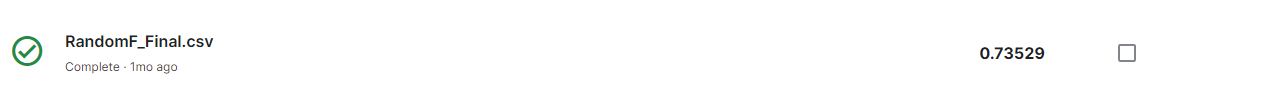